In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
import torch
import torch.nn as nn
import numpy as np
from pathlib import Path

import lightning as pl
import normflows as nf
from normflows.flows.mixing import Invertible1x1Conv
from normflows.flows.affine import GlowBlock
from ciflows.glow import Injective1x1Conv, InjectiveGlowBlock, Squeeze
from ciflows.lightning import plFlowModel
from torchvision.utils import make_grid, save_image
import matplotlib.pyplot as plt

In [17]:


def get_model():
    n_hidden = 64
    n_mixing_layers = 2
    n_injective_layers = 3
    n_glow_blocks = 2
    use_lu = True
    gamma = 1e-2
    activation = "linear"

    input_shape = (1, 28, 28)
    n_channels = input_shape[0]

    n_chs = n_channels
    flows = []

    debug = True

    # add the initial mixing layers
    print("Beginning of mixing flows.")
    mixing_flows = []
    # Add flow layers starting from the latent representation
    for i in range(n_mixing_layers):
        # n_chs = C * 4^(L - i)
        n_chs = n_channels * 4 ** (n_mixing_layers - i)

        if debug:
            print(f"On layer {n_mixing_layers - i}, n_chs = {n_chs}")
        for j in range(n_glow_blocks):
            mixing_flows += [
                GlowBlock(
                    channels=n_chs,
                    hidden_channels=n_hidden,
                    use_lu=use_lu,
                    scale=True,
                )
            ]
        mixing_flows += [Squeeze()]

    # reverse the mixing flows to go from X -> V.
    mixing_flows = mixing_flows[::-1]
    i = 1
    for flow in mixing_flows:
        if hasattr(flow, "n_channels"):
            print(f"On layer {i}, n_chs = {flow.n_channels}")
            i += 1
    num_layers = i

    print("Beginning of injective flows.")
    n_chs = n_channels * 4 ** (n_mixing_layers - 0)
    debug = True
    # add injective blocks
    injective_flows = []
    for i in range(n_injective_layers):
        # Note: this is adding from V -> X
        n_chs = n_chs // 2
        injective_flows += [
            InjectiveGlowBlock(
                channels=n_chs,
                hidden_channels=n_hidden,
                activation=activation,
                scale=True,
                gamma=gamma,
            )
        ]

        if debug:
            print(f"On layer {i + num_layers}, n_chs = {n_chs}")
        for j in range(n_glow_blocks):
            injective_flows += [
                GlowBlock(
                    channels=n_chs,
                    hidden_channels=n_hidden,
                    use_lu=use_lu,
                    scale=True,
                )
            ]

    # Note: this is constructed as X -> V, so we need to reverse the flows
    # to adhere to the normflows convention of V -> X
    flows = mixing_flows
    flows.extend(injective_flows)
    flows = flows[::-1]

    print("n_channels: ", n_chs)
    q0 = nf.distributions.DiagGaussian((n_chs, 7, 7))

    model = nf.NormalizingFlow(q0=q0, flows=flows)

    pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(pytorch_total_params)

    return model



In [27]:
# reload the model from checkpoint
root = Path('/Users/adam2392/pytorch_data/ciflows/')

model_dir = root / 'check_injflow_mnist_v1'
epoch=979
step=421400

model_dir = root / 'check_glowflow_mnist_v1'
epoch=99
step=43000
model_fname = model_dir / f'epoch={epoch}-step={step}.ckpt'


model = plFlowModel.load_from_checkpoint(model_fname)

# model_fname = model_dir / 'check_injflow_mnist_v1-model.pt_final.pt'
# model = torch.load(model_fname, map_location='mps')

/Users/adam2392/miniforge3/envs/ciflows/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


torch.Size([3, 122, 122])


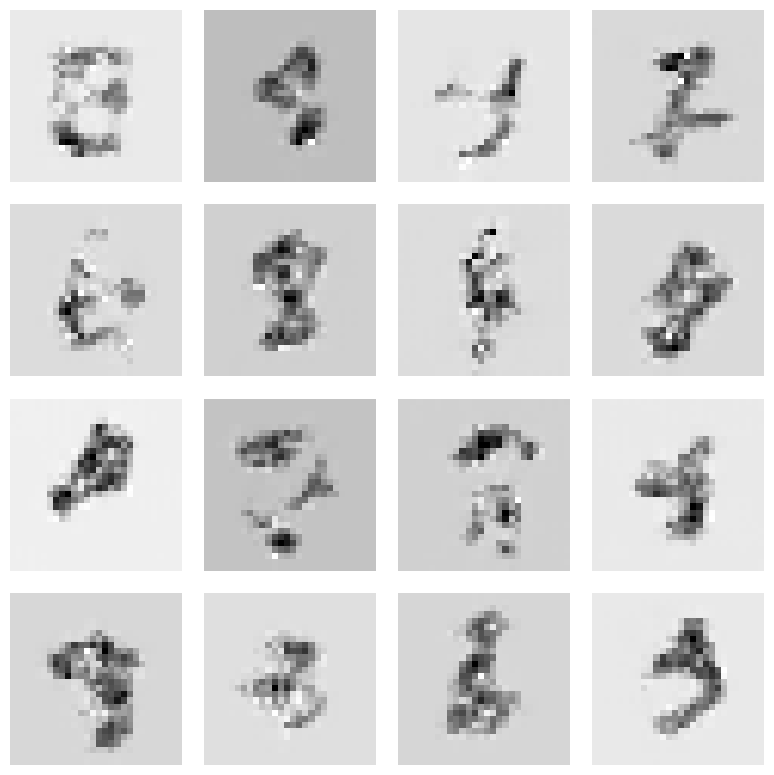

In [28]:

# Step 7: Evaluation
# model.eval()  # Set model to evaluation mode
# with torch.no_grad():
#     loss = evaluate_loss(model, val_loader, device) # Compute loss
#     avg_test_loss = loss.item()  # Accumulate test loss

# print(f'Test Loss: {avg_test_loss:.4f}')

# Step 8: Generate Samples
num_samples = 16
model.eval()
model = model.to(torch.device('cpu'))
with torch.no_grad():
    samples, _ = model.sample(num_samples)  # Generate samples
    samples = samples.view(-1, 1, 28, 28).cpu()  # Reshape for plotting

# Visualize generated samples

# Visualize generated samples
grid_size = make_grid(samples, nrow=4, padding=2)
save_image(grid_size, 'generated_samples.png', normalize=True)

print(grid_size.shape)
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i in range(num_samples):
    ax = axes[i // 4, i % 4]
    ax.imshow(samples[i].squeeze(), cmap='gray')
    ax.axis('off')
plt.show()